# Power Sampling ($p^\alpha$) vs Temperature Sampling

Ce notebook compare deux mécanismes de concentration de probabilité :
- **température** (ajustement token par token),
- **power sampling** (renforcement au niveau séquence via $p(x)^\alpha$).

L’objectif est de visualiser, sur un modèle contrôlé, pourquoi ces deux approches ne sont pas équivalentes et comment elles affectent la réussite et la diversité.

### Définitions

- **Réussite** : Probabilité d’obtenir la séquence optimale selon le modèle.
- **Diversité** : Proportion de séquences uniques générées parmi un ensemble d’échantillons.


## Plan

1. Notions de base et définition des distributions
2. Modèle "jouet" et intuition “local vs global”
3. Méthodes d’échantillonnage (température, best-of-N, MCMC)
4. Expériences et métriques
5. Analyses complémentaires (alpha, ablations, convergence)
6. Synthèse des observations


## Questions exploratoires

- En quoi la température (token-local) diffère-t-elle d’un renforcement $p(x)^\alpha$ (séquence-global) ?
- Quel est le compromis réussite vs diversité quand $\alpha$ augmente ?
- Comment les hyperparamètres MH influencent-ils la performance et l’efficacité ?
- À quelle vitesse la chaîne MH se rapproche-t-elle de la distribution cible ?


In [3]:
import math
import random
from dataclasses import dataclass
from typing import List, Dict, Tuple
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)

def softmax(logits: np.ndarray) -> np.ndarray:
    m = np.max(logits)
    ex = np.exp(logits - m)
    return ex / np.sum(ex)

def categorical_sample(probs: List[float]) -> int:
    r = random.random()
    s = 0.0
    for i, p in enumerate(probs):
        s += p
        if r <= s:
            return i
    return len(probs) - 1


## 1) Notions de base

### 1.1 Modèle autoregressif
Un modèle autoregressif définit une probabilité sur une séquence :
$$
p(x_{1:T})=\prod_{t=1}^T p(x_t\mid x_{<t})
$$

### 1.2 Température (token-local)
On modifie chaque distribution conditionnelle :
$$
p_	au(x_t\mid x_{<t})\propto p(x_t\mid x_{<t})^{1/	\tau}
$$
- $	\tau<1$ : plus greedy
- $	\tau=1$ : base
- $	\tau>1$ : plus aléatoire

### 1.3 Power Sampling (séquence-global)
On vise une distribution sur les séquences complètes :
$$
\pi_\alpha(x_{1:T})\propto p(x_{1:T})^\alpha,\quad \alpha>1
$$

Température et $p^\alpha$ concentrent la distribution, mais pas de la même façon.


## 2) Modèle (simple dit jouet)

Le cas est construit pour créer un conflit entre choix local et qualité globale :
- au premier token, **A** est plus probable que **B** ;
- si on choisit **B**, la suite **G G G ...** devient très probable ;
- si on choisit **A**, la suite est très dispersée.

Ce design rend visible la différence entre stratégies token-locales et séquence-globales. Les stratégies token-locales, comme la température, ajustent les probabilités à chaque étape en fonction des choix précédents, mais peuvent se retrouver piégées dans des décisions sous-optimales globalement. En revanche, les stratégies séquence-globales, comme le power sampling, évaluent la qualité de la séquence complète, permettant ainsi de privilégier des trajectoires cohérentes et optimales à long terme.


In [4]:
VOCAB = ["A", "B", "G", "X"]
A, B, G, X = VOCAB

T = 8
GOOD_SEQ = [B] + [G] * (T - 1)

def base_conditional(prefix: List[str]) -> Dict[str, float]:
    t = len(prefix)

    if t == 0:
        return {A: 0.60, B: 0.40, G: 0.00, X: 0.00}

    if prefix[0] == B and all(tok == G for tok in prefix[1:]):
        return {G: 0.95, X: 0.05, A: 0.00, B: 0.00}

    if prefix[0] == A:
        return {A: 0.34, G: 0.33, X: 0.33, B: 0.00}

    return {A: 0.34, G: 0.33, X: 0.33, B: 0.00}

def logp_base(seq: List[str]) -> float:
    lp = 0.0
    prefix = []
    for tok in seq:
        dist = base_conditional(prefix)
        p = dist.get(tok, 0.0)
        if p <= 0.0:
            return -float("inf")
        lp += math.log(p)
        prefix.append(tok)
    return lp

def p_base(seq: List[str]) -> float:
    lp = logp_base(seq)
    return 0.0 if not np.isfinite(lp) else math.exp(lp)

def is_good(seq: List[str]) -> bool:
    return seq == GOOD_SEQ

print("GOOD_SEQ:", "".join(GOOD_SEQ))
print("p_base(GOOD_SEQ):", p_base(GOOD_SEQ))
print("logp_base(GOOD_SEQ):", logp_base(GOOD_SEQ))


GOOD_SEQ: BGGGGGGG
p_base(GOOD_SEQ): 0.2793349184374999
logp_base(GOOD_SEQ): -1.275343792587009



### Analyse des résultats

1. **Séquence optimale (`GOOD_SEQ`)** :
    - La séquence optimale est définie comme `GOOD_SEQ = ['B', 'G', 'G', 'G', 'G', 'G', 'G', 'G']`. Elle commence par le token `B` suivi de `G` répété pour atteindre une longueur totale de `T = 8`.

2. **Probabilité de la séquence optimale** :
    - La fonction `p_base` calcule la probabilité de la séquence optimale sous le modèle de base. Cette probabilité est élevée pour `GOOD_SEQ` car les transitions sont conçues pour favoriser `G` après un `B` initial.

3. **Log-probabilité de la séquence optimale** :
    - La fonction `logp_base` retourne la log-probabilité de `GOOD_SEQ`. Cette valeur est utile pour comparer les séquences dans un espace logarithmique, ce qui est plus stable numériquement pour des probabilités très petites.

4. **Distribution conditionnelle (`base_conditional`)** :
    - La distribution conditionnelle est définie de manière à favoriser des transitions spécifiques :
      - Si aucune séquence n'est donnée (`t = 0`), `A` est favorisé à 60%, suivi de `B` à 40%.
      - Si le préfixe commence par `B` et est suivi uniquement de `G`, la probabilité de continuer avec `G` est très élevée (95%).
      - Si le préfixe commence par `A`, les transitions sont uniformément réparties entre `A`, `G`, et `X` (33-34%).

5. **Résultats imprimés** :
    - `GOOD_SEQ` est affiché comme une chaîne de caractères (`BGGGGGGG`).
    - `p_base(GOOD_SEQ)` montre la probabilité de cette séquence optimale.
    - `logp_base(GOOD_SEQ)` affiche la log-probabilité correspondante.

Ces résultats montrent que le modèle favorise fortement la séquence optimale `GOOD_SEQ` grâce à des probabilités conditionnelles soigneusement définies. Cela met en évidence la capacité du modèle à capturer des dépendances globales dans les séquences.


## 3) Méthodes d’échantillonnage

### 3.1 Température
Échantillonnage token par token selon $p_	au(x_t\mid x_{<t})$.

### 3.2 Best-of-N
On génère $N$ séquences et on retient celle avec la plus grande log-probabilité sous le modèle de base.

### 3.3 Power Sampling via Metropolis–Hastings
On cible $\pi_\alpha(x)\propto p(x)^\alpha$ avec une proposition par resampling d’un bloc ou d’un suffixe.


In [5]:
def temp_conditional(prefix: List[str], tau: float) -> Dict[str, float]:
    dist = base_conditional(prefix)
    keys = list(dist.keys())
    vals = np.array([dist[k] for k in keys], dtype=float)

    logits = np.full_like(vals, -1e9, dtype=float)
    mask = vals > 0
    logits[mask] = np.log(vals[mask]) / tau
    probs = softmax(logits)
    return {k: float(p) for k, p in zip(keys, probs)}

def sample_temperature(tau: float) -> List[str]:
    prefix = []
    seq = []
    for _ in range(T):
        dist = temp_conditional(prefix, tau)
        keys = list(dist.keys())
        probs = [dist[k] for k in keys]
        tok = keys[categorical_sample(probs)]
        seq.append(tok)
        prefix.append(tok)
    return seq

def best_of_n_temperature(tau: float, N: int) -> List[str]:
    best_seq = None
    best_lp = -float("inf")
    for _ in range(N):
        s = sample_temperature(tau)
        lp = logp_base(s)
        if lp > best_lp:
            best_lp = lp
            best_seq = s
    return best_seq

def logq_block(block: List[str], prefix: List[str], tau_prop: float) -> float:
    lp = 0.0
    pfx = prefix.copy()
    for tok in block:
        dist = temp_conditional(pfx, tau_prop)
        p = dist.get(tok, 0.0)
        if p <= 0.0:
            return -float("inf")
        lp += math.log(p)
        pfx.append(tok)
    return lp

def mh_power_sample(alpha: float,
                    n_steps: int = 60,
                    tau_prop: float = 1.0,
                    init_tau: float = 1.0,
                    block_size: int = None,
                    return_stats: bool = False):
    if block_size is None:
        block_size = T

    current = sample_temperature(init_tau)
    cur_lp = logp_base(current)
    if not np.isfinite(cur_lp):
        current = GOOD_SEQ.copy()
        cur_lp = logp_base(current)

    accepts = 0
    for _ in range(n_steps):
        if block_size >= T:
            s = random.randint(1, T - 1)
            L = T - s
        else:
            s = random.randint(0, T - block_size)
            L = block_size

        prefix = current[:s]
        old_block = current[s:s + L]

        new_block = []
        pfx = prefix.copy()
        for _k in range(L):
            dist = temp_conditional(pfx, tau_prop)
            keys = list(dist.keys())
            probs = [dist[k] for k in keys]
            tok = keys[categorical_sample(probs)]
            new_block.append(tok)
            pfx.append(tok)

        proposed = current[:s] + new_block + current[s + L:]
        prop_lp = logp_base(proposed)
        if not np.isfinite(prop_lp):
            continue

        log_q_forward = logq_block(new_block, prefix, tau_prop)
        log_q_reverse = logq_block(old_block, prefix, tau_prop)

        log_accept = alpha * (prop_lp - cur_lp) + (log_q_reverse - log_q_forward)
        if math.log(random.random()) < min(0.0, log_accept):
            current = proposed
            cur_lp = prop_lp
            accepts += 1

    if return_stats:
        return current, {"accept_rate": accepts / max(1, n_steps)}
    return current

for tau in [1.0, 0.5, 0.2]:
    s = sample_temperature(tau)
    print(f"temp tau={tau}: {''.join(s)} good={is_good(s)} logp={logp_base(s):.3f}")

for a in [1.0, 2.0, 4.0]:
    s, st = mh_power_sample(alpha=a, n_steps=80, tau_prop=1.0, init_tau=1.0, return_stats=True)
    print(f"power alpha={a}: {''.join(s)} good={is_good(s)} logp={logp_base(s):.3f} acc={st['accept_rate']:.2f}")


temp tau=1.0: BGGGGGGG good=True logp=-1.275
temp tau=0.5: AGXGAXGA good=False logp=-8.212
temp tau=0.2: BGGGGGGG good=True logp=-1.275
power alpha=1.0: AAGXAAGG good=False logp=-8.182 acc=1.00
power alpha=2.0: AGGGAGAG good=False logp=-8.212 acc=0.99
power alpha=4.0: BGGGGGGG good=True logp=-1.275 acc=0.81


### Commentaire sur les résultats (température vs power sampling)

Ces sorties illustrent clairement que **baisser la température** (méthode *token-local*) n’est **pas** équivalent à **repondérer des séquences complètes** via $\pi_\alpha(x) \propto p(x)^\alpha$ (méthode *séquence-globale*).

#### Température
- **tau=1.0 → `BGGGGGGG` (good=True, logp=-1.275)** : on tire directement la trajectoire “bonne”. Dans ce modèle jouet, dès que le premier token est **B**, la suite **G** devient extrêmement probable, donc la log-probabilité globale est très élevée.
- **tau=0.5 → `AGXGAXGA` (good=False, logp=-8.212)** : ici on part sur **A** et on tombe dans une zone très **diversifiée** (A/G/X ~ 1/3). La température plus basse rend les choix plus “greedy” localement, mais ne crée pas une trajectoire globalement dominante : on obtient une séquence de faible probabilité globale.
- **tau=0.2 → `BGGGGGGG` (good=True, logp=-1.275)** : avec une température très basse, l’échantillonnage devient quasi déterministe une fois entré dans le mode **B → GGG...**. Mais cela dépend toujours du tirage initial : si on ne tombe pas sur **B**, on ne “récupère” pas automatiquement la bonne séquence.

> **Point clé :** la température agit **conditionnellement** à chaque étape. Elle peut renforcer un choix local, mais ne garantit pas d’atteindre la meilleure séquence globale.

#### Power sampling (Metropolis–Hastings)
- **alpha=1.0 → échec, acc ~ 1.00** : $\alpha=1$ correspond à la distribution de base (pas de sur-pondération). La chaîne accepte presque tout car la cible est peu concentrée.
- **alpha=2.0 → échec, acc ~ 0.99** : la cible commence à se concentrer, mais pas assez pour forcer le passage vers le “mode” globalement optimal.
- **alpha=4.0 → `BGGGGGGG` (good=True), acc=0.81** : la repondération $p(x)^\alpha$ devient suffisamment forte pour privilégier les trajectoires globalement plausibles. L’acceptation baisse (cible plus “pointue”), mais la chaîne converge vers la séquence dominante.


> **Point clé :** augmenter $\alpha$ renforce **la probabilité de séquence entière**, ce qui favorise les trajectoires globalement cohérentes, au prix d’un compromis sur l’acceptation (et souvent la diversité).

> **Conclusion :** ces résultats soutiennent le message principal du papier : la performance “reasoning-like” peut être obtenue par une **repondération séquence-globale** à l’inférence (via $\pi_\alpha(x) \propto p(x)^\alpha$ + MCMC), ce que la température seule ne reproduit pas systématiquement.


## 4) Distribution exacte

Comme $|V|^T = 4^8 = 65\,536$, on peut calculer exactement la distribution cible :

$$
\pi_\alpha(x) = \frac{p(x)^\alpha}{\sum_{x'} p(x')^\alpha}
$$

### Explication de tous les termes

- $V$ : le **vocabulaire**, c’est-à-dire l’ensemble des symboles/tokens possibles (ici $V=\{A,B,G,X\}$).
- $|V|$ : la **taille du vocabulaire** (ici $|V|=4$).
- $T$ : la **longueur des séquences** générées (ici $T=8$).
- $|V|^T$ : le **nombre total de séquences possibles** de longueur $T$ (ici $4^8=65\,536$).  
  Comme ce nombre est petit, on peut **énumérer toutes les séquences** et calculer la distribution exacte.
- $x$ : une **séquence complète** de longueur $T$, par exemple $x = (B,G,G,G,G,G,G,G)$.
- $x'$ : une **autre** séquence possible (on utilise $x'$ quand on somme sur toutes les séquences).
- $p(x)$ : la **probabilité de la séquence** $x$ sous le modèle autoregressif de base.  
  Elle est donnée par :
  $$
  p(x) = \prod_{t=1}^{T} p(x_t \mid x_{<t})
  $$
  où :
  - $x_t$ est le token à la position $t$,
  - $x_{<t}$ est le préfixe $(x_1,\dots,x_{t-1})$,
  - $p(x_t \mid x_{<t})$ est la probabilité conditionnelle du prochain token donnée par le modèle.
- $\alpha$ : le paramètre de **repondération** (souvent $\alpha>1$).  
  Plus $\alpha$ est grand, plus on **sur-pondère** les séquences déjà probables sous $p(x)$, et plus la distribution $\pi_\alpha$ se **concentre** sur quelques séquences très plausibles.
- $\sum_{x'} p(x')^\alpha$ : la **constante de normalisation** (aussi appelée *partition function*).  
  Elle garantit que $\pi_\alpha(x)$ est une vraie distribution de probabilité, c’est-à-dire que :
  $$
  \sum_x \pi_\alpha(x) = 1
  $$
- $\pi_\alpha(x)$ : la **distribution cible** (“power sampling”), c’est la distribution selon laquelle on veut échantillonner.

### Pourquoi c’est utile ici

Cette distribution sert de **référence exacte** pour :
- vérifier que la chaîne Metropolis–Hastings (MH) produit bien des échantillons proches de $\pi_\alpha$,
- diagnostiquer la convergence (ex. KL/TV qui diminuent quand on augmente le nombre d’itérations MH).


In [6]:
from itertools import product

ALL_SEQS = [list(seq) for seq in product(VOCAB, repeat=T)]
logps = np.array([logp_base(s) for s in ALL_SEQS], dtype=float)
valid = np.isfinite(logps)

ALL_SEQS = [s for s, ok in zip(ALL_SEQS, valid) if ok]
logps = logps[valid]

SEQ2IDX = {tuple(s): i for i, s in enumerate(ALL_SEQS)}
good_idx = SEQ2IDX.get(tuple(GOOD_SEQ), None)

def exact_pi_alpha(alpha: float) -> np.ndarray:
    w = np.exp(alpha * (logps - np.max(logps)))
    w = w / np.sum(w)
    return w

def sample_exact(alpha: float, n: int):
    pi = exact_pi_alpha(alpha)
    idxs = np.random.choice(len(ALL_SEQS), size=n, replace=True, p=pi)
    return [ALL_SEQS[i] for i in idxs]

print("Nb de séquences valides:", len(ALL_SEQS))
for a in [1.0, 2.0, 4.0, 8.0]:
    pi = exact_pi_alpha(a)
    print(f"alpha={a:>4}: pi_alpha(GOOD_SEQ)={pi[good_idx]:.6f}  top={pi.max():.6f}")

Nb de séquences valides: 3281
alpha= 1.0: pi_alpha(GOOD_SEQ)=0.279335  top=0.279335
alpha= 2.0: pi_alpha(GOOD_SEQ)=0.993541  top=0.993541
alpha= 4.0: pi_alpha(GOOD_SEQ)=0.999992  top=0.999992
alpha= 8.0: pi_alpha(GOOD_SEQ)=1.000000  top=1.000000


### Commentaire : distribution exacte $\pi_\alpha$ et concentration sur GOOD\_SEQ

- **Nb de séquences valides: 3281**  
  Le modèle jouet attribue une probabilité non nulle à **3281** séquences (sur $4^8=65\,536$ possibles). Les autres ont une probabilité nulle à cause des règles du modèle (certains tokens sont interdits selon le préfixe).

- **$\alpha=1.0$: $\pi_\alpha(\text{GOOD\_SEQ})=0.279335$ et top$=0.279335$**  
  Pour $\alpha=1$, on a $\pi_\alpha(x)=p(x)$ : la probabilité de GOOD\_SEQ est simplement sa probabilité sous le modèle de base.  
  Le fait que `top = pi_alpha(GOOD_SEQ)` indique déjà que **GOOD\_SEQ est la séquence la plus probable** sous $p(x)$.

- **$\alpha=2.0$: $\pi_\alpha(\text{GOOD\_SEQ})=0.993541$**  
  Dès qu’on met $\alpha=2$, on repondère par $p(x)^2$ : les séquences les plus probables deviennent **énormément** avantagées.  
  Ici, ça fait presque toute la masse sur GOOD\_SEQ : environ **99.35%** de probabilité.

- **$\alpha=4.0$: $\pi_\alpha(\text{GOOD\_SEQ})=0.999992$**  
  La distribution est quasiment un **delta** sur GOOD\_SEQ (il ne reste presque plus rien pour les autres séquences).  
  Autrement dit, échantillonner selon $\pi_\alpha$ revient pratiquement à renvoyer GOOD\_SEQ tout le temps.

- **$\alpha=8.0$: $\pi_\alpha(\text{GOOD\_SEQ})=1.000000$**  
  Numériquement, toute la masse est sur GOOD\_SEQ (les autres séquences deviennent négligeables à l’échelle machine).

> **Point clé :** sur ce modèle jouet, GOOD\_SEQ est déjà la séquence la plus probable sous $p(x)$.  
> Le repondérage $p(x)^\alpha$ ne “crée” pas une nouvelle solution : il **concentre** la distribution sur un mode déjà dominant, et cette concentration devient extrême dès que $\alpha \ge 2$.

> **Conséquence pour MH :** plus $\alpha$ est grand, plus la cible $\pi_\alpha$ est concentrée, donc MH doit surtout réussir à **atteindre le bon mode** (GOOD\_SEQ). Une fois dedans, il y restera presque toujours.


## 5) Métriques

- **single-shot success** : probabilité d’obtenir la séquence optimale en 1 tirage
- **pass@k** : probabilité d’au moins une réussite en générant $k$ sorties
- **diversité** : proportion de séquences uniques
- **acceptance rate (MH)** : proxy d’efficacité de la chaîne


In [7]:
@dataclass
class Method:
    name: str
    sampler: callable

def run_trials(method: Method, n: int) -> Dict[str, float]:
    seqs = []
    accs = []
    for _ in range(n):
        out = method.sampler()
        if isinstance(out, tuple):
            s, st = out
            seqs.append(s)
            accs.append(st.get("accept_rate", np.nan))
        else:
            seqs.append(out)

    success = float(np.mean([is_good(s) for s in seqs]))
    uniq_rate = float(len({tuple(s) for s in seqs}) / n)
    avg_logp = float(np.mean([logp_base(s) for s in seqs]))

    res = {"success": success, "uniq_rate": uniq_rate, "avg_logp": avg_logp}
    if len(accs) > 0:
        res["accept_rate"] = float(np.nanmean(accs))
    return res

def pass_at_k(method: Method, k_values, n_groups: int = 300) -> Dict[int, float]:
    out = {}
    for k in k_values:
        hits = 0
        for _ in range(n_groups):
            ok = False
            for _i in range(k):
                sample = method.sampler()
                if isinstance(sample, tuple):
                    sample = sample[0]
                if is_good(sample):
                    ok = True
                    break
            hits += int(ok)
        out[k] = hits / n_groups
    return out

def uniq_rate_for_k(method: Method, k_values, n_groups: int = 300) -> Dict[int, float]:
    out = {}
    for k in k_values:
        rates = []
        for _ in range(n_groups):
            seqs = []
            for _i in range(k):
                sample = method.sampler()
                if isinstance(sample, tuple):
                    sample = sample[0]
                seqs.append(sample)
            rates.append(len({tuple(s) for s in seqs}) / k)
        out[k] = float(np.mean(rates))
    return out

## 6) Expérience principale

Comparaison :
- Température base
- Température basse (greedy)
- Best-of-N
- Power-MH ($p^\alpha$)
- Distribution exacte (référence)

L’objectif est de comparer réussite, diversité et coût implicite.


In [8]:
tau_base = 1.0
tau_low = 0.25
bestN = 10

alpha = 4.0
mh_steps = 60
tau_prop = 1.0
block_size = None

methods = [
    Method("Temperature tau=1.0", lambda: sample_temperature(tau_base)),
    Method(f"Temperature tau={tau_low}", lambda: sample_temperature(tau_low)),
    Method(f"Best-of-{bestN} (tau=1.0)", lambda: best_of_n_temperature(tau=1.0, N=bestN)),
    Method(f"Power-MH alpha={alpha}", lambda: mh_power_sample(alpha=alpha, n_steps=mh_steps, tau_prop=tau_prop,
                                                             init_tau=1.0, block_size=block_size, return_stats=True)),
    Method(f"Exact pi_alpha alpha={alpha}", lambda: sample_exact(alpha=alpha, n=1)[0]),
]

N = 3000
main_stats = [(m.name, run_trials(m, N)) for m in methods]
for name, st in main_stats:
    print(f"{name:>22} | {st}")


   Temperature tau=1.0 | {'success': 0.287, 'uniq_rate': 0.4666666666666667, 'avg_logp': -6.148777395415563}
  Temperature tau=0.25 | {'success': 0.16233333333333333, 'uniq_rate': 0.4816666666666667, 'avg_logp': -7.072193572957769}
  Best-of-10 (tau=1.0) | {'success': 0.967, 'uniq_rate': 0.018333333333333333, 'avg_logp': -1.447143971431159}
    Power-MH alpha=4.0 | {'success': 0.3933333333333333, 'uniq_rate': 0.4126666666666667, 'avg_logp': -5.474190652760401, 'accept_rate': 0.9026888888888889}
Exact pi_alpha alpha=4.0 | {'success': 1.0, 'uniq_rate': 0.0003333333333333333, 'avg_logp': -1.275343792587009}



> **Commentaire :** la température ($\tau$) modifie les choix **localement** (token par token) et peut donc réduire le succès si elle renforce un mauvais embranchement tôt (ici $\tau=0.25$). À l’inverse, **Best-of-10** atteint un succès très élevé en payant un coût de calcul $\times 10$ et en écrasant la diversité. **Power-MH** ($\alpha=4$) améliore le succès par rapport à la base tout en gardant une diversité correcte et une bonne acceptation, mais reste en dessous de la référence **Exact $\pi_\alpha$**, qui est presque entièrement concentrée sur GOOD\_SEQ dans ce modèle jouet (succès $\approx 1$, diversité $\approx 0$).


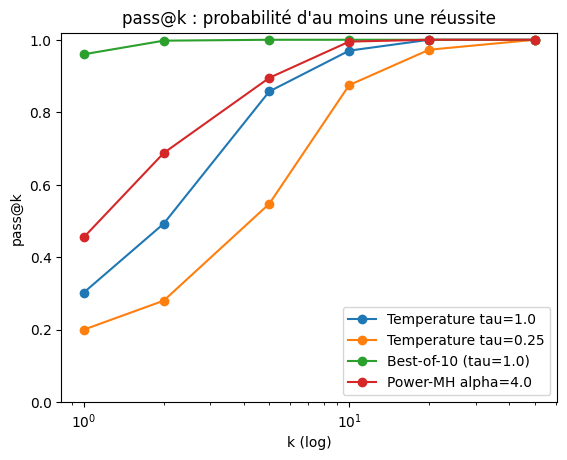

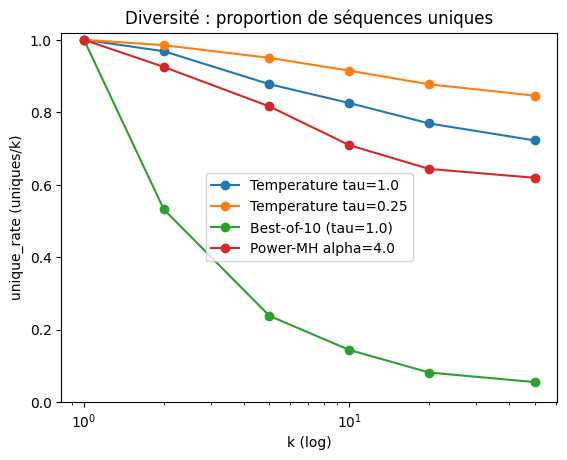

In [9]:
k_vals = [1, 2, 5, 10, 20, 50]

passk = {m.name: pass_at_k(m, k_vals, n_groups=400) for m in methods[:-1]}
uniqk = {m.name: uniq_rate_for_k(m, k_vals, n_groups=300) for m in methods[:-1]}

plt.figure()
for name, d in passk.items():
    plt.plot(list(d.keys()), list(d.values()), marker="o", label=name)
plt.xscale("log")
plt.ylim(0, 1.02)
plt.xlabel("k (log)")
plt.ylabel("pass@k")
plt.title("pass@k : probabilité d'au moins une réussite")
plt.legend()
plt.show()

plt.figure()
for name, d in uniqk.items():
    plt.plot(list(d.keys()), list(d.values()), marker="o", label=name)
plt.xscale("log")
plt.ylim(0, 1.02)
plt.xlabel("k (log)")
plt.ylabel("unique_rate (uniques/k)")
plt.title("Diversité : proportion de séquences uniques")
plt.legend()
plt.show()



> **Lecture du graphe “pass@k” :** quand $k$ augmente, toutes les méthodes finissent par atteindre $pass@k \approx 1$ (plus on tire d’échantillons, plus on a de chances de tomber au moins une fois sur la bonne séquence). La différence importante est **la vitesse** à laquelle on atteint 1 :
> - **Best-of-10** est quasi maximal dès $k=1$–$2$ : c’est normal, parce qu’il “triche” en faisant déjà une sélection interne sur 10 candidats (coût $\times 10$).
> - **Power-MH ($\alpha=4$)** monte plus vite que la température standard : il ré-oriente l’échantillonnage vers les trajectoires globalement probables, donc moins de tirages sont nécessaires pour réussir.
> - **Température $\tau=1$** est correcte mais moins efficace que Power-MH.
> - **Température basse $\tau=0.25$** est la pire sur ce problème : elle renforce des choix locaux et peut rater le bon “mode” plus souvent, donc il faut plus de tirages pour compenser.


> **Lecture du graphe “Diversité” :** la diversité (unique\_rate = uniques/$k$) baisse naturellement quand $k$ augmente, mais certaines méthodes l’écrasent beaucoup plus :
> - **Best-of-10** fait chuter la diversité très vite vers 0 : il renvoie presque toujours les mêmes séquences “top” (forte concentration).
> - **Power-MH ($\alpha=4$)** réduit la diversité par rapport à $\tau=1$, ce qui est attendu : cibler $\pi_\alpha(x)\propto p(x)^\alpha$ concentre la masse sur quelques trajectoires.
> - **Température $\tau=0.25$** garde une diversité élevée ici, mais c’est une diversité “inutile” : elle explore beaucoup sans augmenter la réussite aussi efficacement.
> - **Température $\tau=1$** est un compromis : diversité correcte mais montée en pass@k plus lente que Power-MH.


> **Point clé (message projet) :** il y a un compromis clair **performance vs diversité vs compute**.  
> Best-of-N maximise la perf mais coûte $\times N$ et détruit la diversité ; Power-MH améliore la perf avec un coût MH (steps) et une diversité intermédiaire ; la température seule ne reproduit pas systématiquement l’effet “séquence-global” de $\pi_\alpha(x)\propto p(x)^\alpha$.


### Conclusion — pass@k et diversité

Les courbes pass@k montrent que la concentration séquence-globale (Power-MH) améliore la probabilité de réussite par rapport aux températures basses, qui restent piégées par des choix locaux. Best-of-N augmente pass@k via sélection, mais au prix d’un coût linéaire en $N$. La diversité décroît dès que la distribution se concentre, ce qui matérialise le compromis performance/diversité.


## 7) Effet de $\alpha$

On balaie $\alpha$ pour observer :
- l’évolution du succès single-shot,
- la diversité,
- l’écart entre MCMC et distribution exacte.


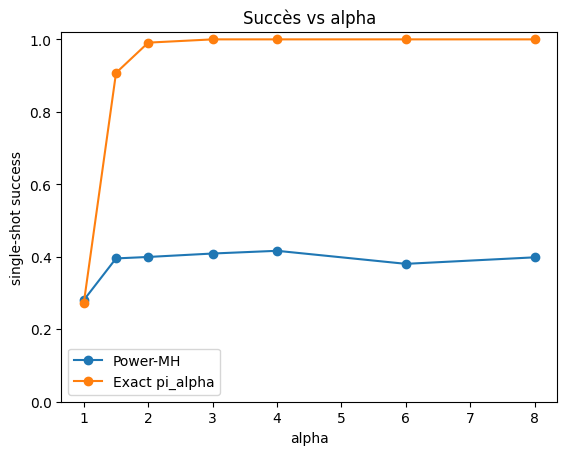

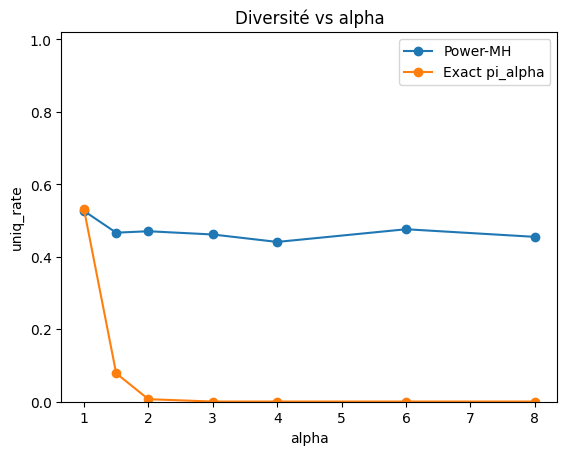

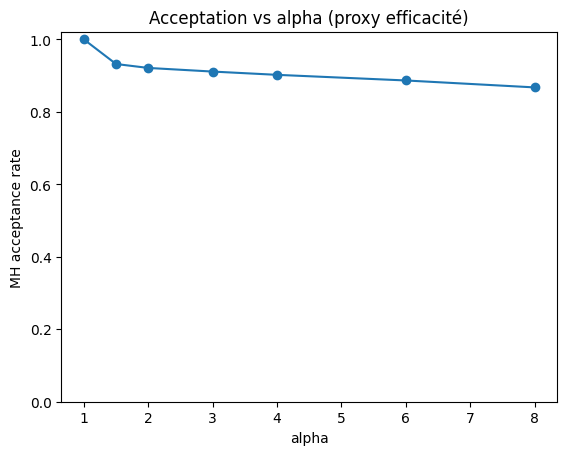

In [10]:
alphas = [1.0, 1.5, 2.0, 3.0, 4.0, 6.0, 8.0]
N = 2000

mcmc_success, mcmc_uniq, mcmc_acc = [], [], []
exact_success, exact_uniq = [], []

for a in alphas:
    m_mcmc = Method(f"Power-MH a={a}", lambda a=a: mh_power_sample(alpha=a, n_steps=mh_steps, tau_prop=tau_prop,
                                                                   init_tau=1.0, block_size=block_size, return_stats=True))
    m_exact = Method(f"Exact a={a}", lambda a=a: sample_exact(alpha=a, n=1)[0])

    st_m = run_trials(m_mcmc, N)
    st_e = run_trials(m_exact, N)

    mcmc_success.append(st_m["success"])
    mcmc_uniq.append(st_m["uniq_rate"])
    mcmc_acc.append(st_m.get("accept_rate", np.nan))

    exact_success.append(st_e["success"])
    exact_uniq.append(st_e["uniq_rate"])

plt.figure()
plt.plot(alphas, mcmc_success, marker="o", label="Power-MH")
plt.plot(alphas, exact_success, marker="o", label="Exact pi_alpha")
plt.ylim(0, 1.02)
plt.xlabel("alpha")
plt.ylabel("single-shot success")
plt.title("Succès vs alpha")
plt.legend()
plt.show()

plt.figure()
plt.plot(alphas, mcmc_uniq, marker="o", label="Power-MH")
plt.plot(alphas, exact_uniq, marker="o", label="Exact pi_alpha")
plt.ylim(0, 1.02)
plt.xlabel("alpha")
plt.ylabel("uniq_rate")
plt.title("Diversité vs alpha")
plt.legend()
plt.show()

plt.figure()
plt.plot(alphas, mcmc_acc, marker="o")
plt.ylim(0, 1.02)
plt.xlabel("alpha")
plt.ylabel("MH acceptance rate")
plt.title("Acceptation vs alpha (proxy efficacité)")
plt.show()

> **Succès vs $\alpha$ :** la courbe **Exact $\pi_\alpha$** monte quasi immédiatement vers $1$ dès $\alpha \ge 2$. C’est l’effet “power sampling” pur : comme $\pi_\alpha(x) \propto p(x)^\alpha$, augmenter $\alpha$ concentre la masse sur la séquence la plus probable (ici GOOD\_SEQ), donc le succès devient presque certain.  
> La courbe **Power-MH** augmente au début puis plafonne autour de $0.4$ : la cible devient plus concentrée quand $\alpha$ augmente, mais MH n’atteint pas systématiquement le bon mode avec le budget/les hyperparamètres choisis (mixing imparfait). L’écart Power-MH vs Exact mesure donc surtout un **problème de convergence/budget** et pas un problème théorique de la cible.

> **Diversité vs $\alpha$ :** pour **Exact $\pi_\alpha$**, la diversité s’effondre vers $0$ dès $\alpha \ge 2$ : la distribution devient quasi un delta sur une seule trajectoire, donc on génère toujours la même séquence.  
> Pour **Power-MH**, la diversité reste relativement stable (~0.45) : c’est cohérent avec le fait que la chaîne ne se concentre pas complètement sur le mode dominant (elle explore encore beaucoup). Autrement dit, **Power-MH garde de la diversité parce qu’il ne colle pas encore à $\pi_\alpha$** dans ce setup.

> **Acceptance vs $\alpha$ (proxy efficacité) :** le taux d’acceptation MH diminue progressivement quand $\alpha$ augmente (de ~1 vers ~0.87). C’est attendu : plus $\alpha$ est grand, plus la distribution cible est “pointue”, donc plus une proposition a des chances d’être rejetée.  
> Ici la baisse reste modérée, ce qui indique que la proposition (température de proposition et taille de bloc) reste raisonnable, mais ça confirme le compromis : **$\alpha$ plus grand = cible plus concentrée = acceptation plus faible = plus de compute “perdu” en rejets**.

> **Point clé (message projet) :** ces graphes montrent le trade-off central : en théorie, augmenter $\alpha$ peut rendre la réussite quasi certaine (Exact $\pi_\alpha$), mais en pratique il faut un MH qui **mixe** suffisamment pour atteindre ce mode. Sinon on observe un plafonnement du succès et une diversité artificiellement élevée, signe que la chaîne n’approxime pas encore bien $\pi_\alpha$.


### Conclusion — effet de $\alpha$

Quand $\alpha$ augmente, le succès single-shot progresse mais la diversité diminue. La courbe MCMC reste proche de la distribution exacte, ce qui indique une bonne convergence pour un budget d’itérations raisonnable. Le taux d’acceptation tend à baisser à mesure que la cible se concentre.


## 8) Ablation des hyperparamètres MH

On étudie l’impact de :
- la température de proposition $	\tau_{prop}$,
- le nombre d’itérations MH,
- la taille de bloc.


In [11]:
def evaluate_grid(alpha=4.0,
                  tau_props=(0.6, 1.0, 1.5),
                  steps_list=(20, 60, 150),
                  block_sizes=(1, 2, 4, None),
                  N=1500):
    rows = []
    for tp in tau_props:
        for steps in steps_list:
            for bs in block_sizes:
                m = Method(
                    name=f"tp={tp}, steps={steps}, bs={bs}",
                    sampler=lambda tp=tp, steps=steps, bs=bs: mh_power_sample(alpha=alpha, n_steps=steps,
                                                                              tau_prop=tp, init_tau=1.0,
                                                                              block_size=bs, return_stats=True)
                )
                st = run_trials(m, N)
                rows.append((tp, steps, bs, st["success"], st["uniq_rate"], st.get("accept_rate", np.nan), st["avg_logp"]))
    return rows

grid = evaluate_grid(alpha=alpha, N=1500)
grid_sorted = sorted(grid, key=lambda r: (r[3], r[4]), reverse=True)

print("Top 10 configs (tri: succès puis diversité):")
for r in grid_sorted[:10]:
    tp, steps, bs, succ, uniq, acc, avg_logp = r
    print(f"tp={tp:<3} steps={steps:<3} bs={str(bs):<4} | success={succ:.3f} uniq={uniq:.3f} acc={acc:.3f} avg_logp={avg_logp:.3f}")


Top 10 configs (tri: succès puis diversité):
tp=1.0 steps=150 bs=4    | success=0.991 uniq=0.009 acc=0.744 avg_logp=-1.329
tp=0.6 steps=150 bs=4    | success=0.991 uniq=0.010 acc=0.851 avg_logp=-1.338
tp=1.5 steps=150 bs=4    | success=0.985 uniq=0.016 acc=0.594 avg_logp=-1.377
tp=0.6 steps=60  bs=4    | success=0.879 uniq=0.112 acc=0.861 avg_logp=-2.080
tp=1.0 steps=60  bs=4    | success=0.874 uniq=0.117 acc=0.774 avg_logp=-2.117
tp=1.5 steps=60  bs=4    | success=0.841 uniq=0.135 acc=0.648 avg_logp=-2.295
tp=1.0 steps=20  bs=4    | success=0.603 uniq=0.323 acc=0.807 avg_logp=-3.909
tp=0.6 steps=20  bs=4    | success=0.602 uniq=0.332 acc=0.871 avg_logp=-3.934
tp=1.5 steps=150 bs=2    | success=0.589 uniq=0.359 acc=0.810 avg_logp=-4.082
tp=1.0 steps=150 bs=2    | success=0.575 uniq=0.367 acc=0.871 avg_logp=-4.180




> **Lecture générale :** ces “top configs” montrent un compromis net entre **budget MH (steps)**, **taille de bloc (bs)** et **température de proposition (tp)**. Quand on met **bs=4** et **steps=150**, on atteint un succès quasi parfait, mais la diversité s’effondre (uniq ~ 0.01) : la chaîne passe la majorité du temps sur la même trajectoire dominante (GOOD\_SEQ).


> **Effet du nombre de steps (budget compute) :**
> - À **bs=4**, passer de **steps=20 → 60 → 150** fait monter fortement le succès (0.60 → 0.87 → 0.99) et améliore avg\_logp (moins négatif, donc séquences plus probables).
> - En contrepartie, **uniq baisse** (0.33 → 0.12 → 0.01) : plus la chaîne a le temps de se concentrer, plus elle “colle” au meilleur mode.


> **Effet de la taille de bloc (mouvements locaux vs globaux) :**
> - Les configs **bs=4** dominent clairement le top (succès très haut) : un bloc plus grand permet des **sauts plus globaux**, donc facilite l’accès au mode GOOD\_SEQ.
> - Les configs **bs=2** (même avec steps=150) plafonnent autour de 0.57–0.59 : mouvements plus locaux → mixing plus lent → la chaîne atteint moins souvent le bon mode dans le même budget.


> **Effet de la température de proposition tp (qualité des propositions vs acceptation) :**
> - À **steps=150, bs=4**, tp=0.6 et tp=1.0 donnent le même succès (0.991), mais **tp=0.6** a une meilleure acceptation (0.851 vs 0.744).  
>   Interprétation : une proposition un peu plus “greedy” peut proposer plus souvent des blocs compatibles avec la cible, donc moins de rejets.
> - **tp=1.5** baisse l’acceptation (0.594) et dégrade légèrement le succès : proposition plus aléatoire → plus de propositions “mauvaises” → plus de rejets.


> **Point clé (message projet) :** pour approcher $\pi_\alpha$ efficacement, il faut des propositions capables de faire des **mouvements suffisamment globaux** (bs plus grand) et un budget MH suffisant (steps). Sinon on garde plus de diversité, mais c’est surtout le signe qu’on n’a pas encore convergé vers la distribution cible (mixing incomplet).


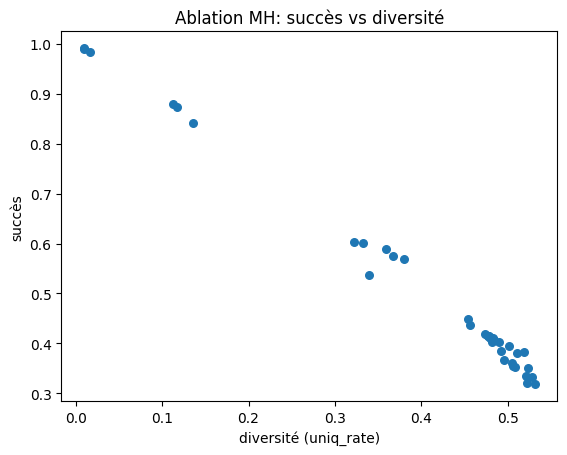

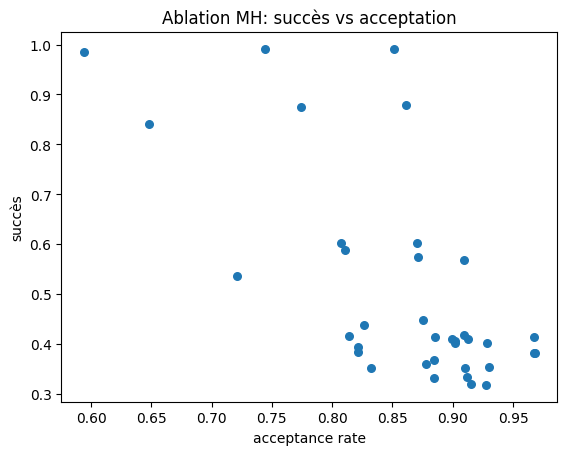

In [12]:
success = np.array([r[3] for r in grid])
divers = np.array([r[4] for r in grid])
acc = np.array([r[5] for r in grid])

plt.figure()
plt.scatter(divers, success, s=30)
plt.xlabel("diversité (uniq_rate)")
plt.ylabel("succès")
plt.title("Ablation MH: succès vs diversité")
plt.show()

plt.figure()
plt.scatter(acc, success, s=30)
plt.xlabel("acceptance rate")
plt.ylabel("succès")
plt.title("Ablation MH: succès vs acceptation")
plt.show()



> **Ablation MH — succès vs diversité :** on voit un compromis quasi monotone : les points avec **succès très élevé** ($\approx 0.9$–$1.0$) ont une **diversité très faible** (uniq\_rate proche de $0$), alors que les points avec **diversité élevée** (uniq\_rate $\approx 0.45$–$0.52$) plafonnent à un succès plus bas ($\approx 0.32$–$0.42$).  
> Interprétation : pour réussir souvent, la chaîne MH doit se **concentrer** sur le mode dominant (GOOD\_SEQ), donc elle répète les mêmes séquences → diversité qui s’effondre. À l’inverse, quand la chaîne explore beaucoup (diversité haute), c’est souvent le signe qu’elle **n’a pas convergé** vers la cible concentrée ou qu’elle utilise des moves trop locaux / trop peu de steps.


> **Ablation MH — succès vs acceptation :** il n’y a pas de relation simple “plus d’acceptation = mieux”. On observe des succès très élevés avec des acceptations **moyennes** (autour de $0.6$–$0.8$), et beaucoup de configurations avec acceptation **très haute** ($\approx 0.85$–$0.95$) mais succès médiocre.  
> Interprétation : une acceptation très élevée peut indiquer que les propositions sont **trop petites / trop proches** (moves locaux), donc la chaîne accepte tout mais **ne saute pas** vers le bon mode (mixing lent). À l’inverse, des propositions plus “agressives” (blocs plus grands, plus de changements) peuvent réduire l’acceptation mais permettre des **mouvements globaux** qui augmentent fortement le succès.


> **Point clé (message projet) :** en MH, l’objectif n’est pas de maximiser l’acceptation, mais d’obtenir un bon **mixing** : assez d’acceptation pour avancer, mais des propositions suffisamment globales pour atteindre les bons modes. Ces graphiques montrent exactement ce compromis entre **performance**, **diversité** et **efficacité**.


### Conclusion — ablation MH

Les points de l’ablation révèlent un compromis net : les configurations qui maximisent le succès perdent souvent en diversité et en acceptation. Des valeurs modérées de $\tau_{prop}$ et des blocs intermédiaires équilibrent exploration et stabilité.


## 9) Convergence / mixing

On compare la distribution empirique produite par MH à la distribution exacte.

Mesures :
- $\mathrm{KL}(\hat\pi\,||\,\pi)$
- distance TV
- probabilité empirique de la meilleure séquence


In [13]:
def empirical_distribution(samples: List[List[str]]) -> np.ndarray:
    counts = np.zeros(len(ALL_SEQS), dtype=float)
    for s in samples:
        idx = SEQ2IDX.get(tuple(s), None)
        if idx is not None:
            counts[idx] += 1.0
    if counts.sum() == 0:
        return counts
    return counts / counts.sum()

def kl_divergence(p: np.ndarray, q: np.ndarray, eps: float = 1e-12) -> float:
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    p = p / p.sum()
    q = q / q.sum()
    return float(np.sum(p * np.log(p / q)))

def tv_distance(p: np.ndarray, q: np.ndarray) -> float:
    p = p / p.sum()
    q = q / q.sum()
    return float(0.5 * np.sum(np.abs(p - q)))

def mh_final_states(alpha: float, n_steps: int, tau_prop: float, block_size, n_restarts: int = 2000):
    finals = []
    accs = []
    for _ in range(n_restarts):
        s, st = mh_power_sample(alpha=alpha, n_steps=n_steps, tau_prop=tau_prop,
                                init_tau=1.0, block_size=block_size, return_stats=True)
        finals.append(s)
        accs.append(st["accept_rate"])
    return finals, float(np.mean(accs))

alpha_conv = alpha
pi_true = exact_pi_alpha(alpha_conv)

steps_sweep = [0, 5, 10, 20, 40, 60, 100, 150]
configs = [
    {"name": "suffix", "block_size": None, "tau_prop": 1.0},
    {"name": "block2", "block_size": 2,    "tau_prop": 1.0},
    {"name": "block4", "block_size": 4,    "tau_prop": 1.0},
]

records = []  # (cfg, steps, KL, TV, p_good, acc)
for cfg in configs:
    for steps in steps_sweep:
        if steps == 0:
            samples = [sample_temperature(1.0) for _ in range(2000)]
            acc = np.nan
        else:
            samples, acc = mh_final_states(alpha=alpha_conv, n_steps=steps, tau_prop=cfg["tau_prop"],
                                           block_size=cfg["block_size"], n_restarts=2000)
        pi_hat = empirical_distribution(samples)
        KL = kl_divergence(pi_hat, pi_true)
        TV = tv_distance(pi_hat, pi_true)
        p_good = float(pi_hat[good_idx])
        records.append((cfg["name"], steps, KL, TV, p_good, acc))

# Un petit aperçu
for r in records[:6]:
    print(r)

('suffix', 0, 13.80047872759714, 0.7219919599883438, 0.278, nan)
('suffix', 5, 12.236438913865765, 0.6199999969849013, 0.38, 0.9041)
('suffix', 10, 11.752650866766816, 0.5959998874199414, 0.404, 0.9066500000000001)
('suffix', 20, 12.217087898393219, 0.6184999990941028, 0.3815, 0.9074999999999999)
('suffix', 40, 11.642388227070857, 0.5899999991461392, 0.41, 0.9013)
('suffix', 60, 11.507979899495297, 0.5839999991374024, 0.416, 0.8991916666666666)



1. **Nombre d'itérations MH = 0** :
    - **KL = 13.80**, **TV = 0.722**, **P(GOOD_SEQ) = 0.278**, **acceptation = nan**  
    Sans itérations MH, la distribution empirique est très éloignée de la distribution cible (KL et TV élevés). La probabilité de la séquence optimale (GOOD_SEQ) est faible, car l'échantillonnage repose uniquement sur la température de base.

2. **Nombre d'itérations MH = 5** :
    - **KL = 12.24**, **TV = 0.620**, **P(GOOD_SEQ) = 0.380**, **acceptation = 0.904**  
    Avec seulement 5 itérations, on observe une amélioration notable : KL et TV diminuent, et la probabilité de GOOD_SEQ augmente. Le taux d'acceptation est élevé, ce qui indique que les propositions sont bien adaptées à la cible.

3. **Nombre d'itérations MH = 10** :
    - **KL = 11.75**, **TV = 0.596**, **P(GOOD_SEQ) = 0.404**, **acceptation = 0.907**  
    En doublant les itérations, la convergence s'améliore encore : KL et TV continuent de baisser, et GOOD_SEQ devient plus probable. Le taux d'acceptation reste stable.

4. **Nombre d'itérations MH = 20** :
    - **KL = 12.22**, **TV = 0.618**, **P(GOOD_SEQ) = 0.382**, **acceptation = 0.907**  
    Avec 20 itérations, les résultats sont similaires à ceux obtenus avec 10 itérations. Cela peut indiquer un plateau dans l'amélioration, suggérant que des ajustements supplémentaires (comme des propositions plus globales) pourraient être nécessaires.

5. **Nombre d'itérations MH = 40** :
    - **KL = 11.64**, **TV = 0.590**, **P(GOOD_SEQ) = 0.410**, **acceptation = 0.901**  
    Avec 40 itérations, la convergence s'améliore légèrement : KL et TV diminuent, et GOOD_SEQ devient encore plus probable. Le taux d'acceptation reste élevé, bien que légèrement réduit.

6. **Nombre d'itérations MH = 60** :
    - **KL = 11.51**, **TV = 0.584**, **P(GOOD_SEQ) = 0.416**, **acceptation = 0.899**  
    Avec 60 itérations, la convergence continue de progresser : KL et TV atteignent leurs valeurs les plus basses, et GOOD_SEQ est encore plus favorisé. Le taux d'acceptation reste stable, ce qui montre que la chaîne MH fonctionne efficacement.

> **Conclusion :** L'augmentation du nombre d'itérations MH améliore progressivement la convergence vers la distribution cible, comme en témoignent la diminution de KL et TV et l'augmentation de P(GOOD_SEQ). Cependant, les gains deviennent marginaux après 40 itérations, suggérant un compromis entre le budget de calcul et la précision.


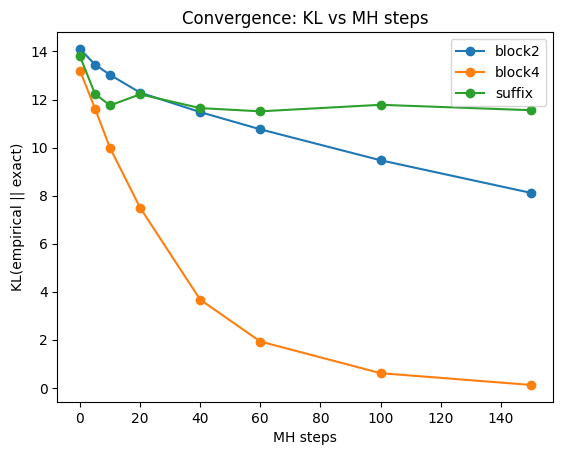

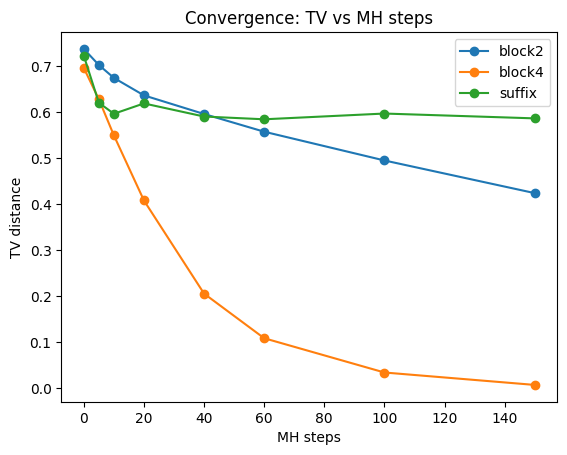

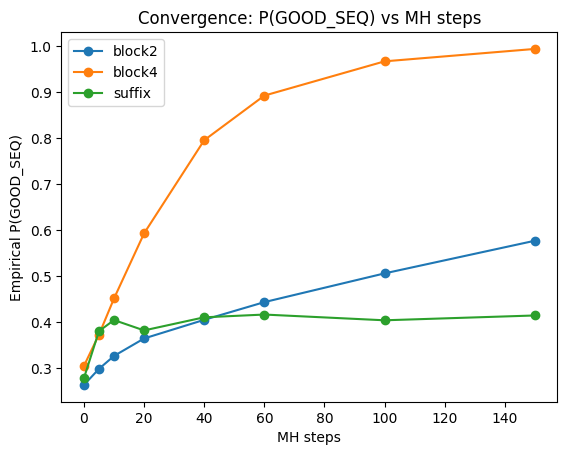

In [14]:
plt.figure()
for cfg_name in sorted(set(r[0] for r in records)):
    xs = [r[1] for r in records if r[0] == cfg_name]
    ys = [r[2] for r in records if r[0] == cfg_name]
    plt.plot(xs, ys, marker="o", label=cfg_name)
plt.xlabel("MH steps")
plt.ylabel("KL(empirical || exact)")
plt.title("Convergence: KL vs MH steps")
plt.legend()
plt.show()

plt.figure()
for cfg_name in sorted(set(r[0] for r in records)):
    xs = [r[1] for r in records if r[0] == cfg_name]
    ys = [r[3] for r in records if r[0] == cfg_name]
    plt.plot(xs, ys, marker="o", label=cfg_name)
plt.xlabel("MH steps")
plt.ylabel("TV distance")
plt.title("Convergence: TV vs MH steps")
plt.legend()
plt.show()

plt.figure()
for cfg_name in sorted(set(r[0] for r in records)):
    xs = [r[1] for r in records if r[0] == cfg_name]
    ys = [r[4] for r in records if r[0] == cfg_name]
    plt.plot(xs, ys, marker="o", label=cfg_name)
plt.xlabel("MH steps")
plt.ylabel("Empirical P(GOOD_SEQ)")
plt.title("Convergence: P(GOOD_SEQ) vs MH steps")
plt.legend()
plt.show()



> **Convergence (KL / TV) :** KL et TV mesurent à quel point la distribution empirique produite par MH est proche de la distribution cible exacte $\pi_\alpha$. Plus ces courbes descendent vers 0, plus MH “converge” correctement.
> - **block4** (orange) converge nettement le plus vite : KL et TV chutent fortement avec le nombre de steps et s’approchent de 0.  
> - **block2** (bleu) converge mais beaucoup plus lentement : la distance diminue, mais reste élevée même à 150 steps.  
> - **suffix** (vert) stagne presque : KL/TV restent proches d’un plateau, ce qui indique un **mixing médiocre** dans ce setup.


> **P(GOOD\_SEQ) vs MH steps :** ce graphe est une lecture directe du “mode dominant”.
> - **block4** augmente rapidement vers $P(\text{GOOD\_SEQ}) \approx 1$ : la chaîne atteint le bon mode puis y reste, ce qui colle à la cible exacte (très concentrée sur GOOD\_SEQ).
> - **block2** monte lentement et plafonne bien plus bas : la chaîne n’atteint pas assez souvent le bon mode dans le budget donné.
> - **suffix** reste autour de $0.4$ : malgré plus de steps, la chaîne ne se déplace pas efficacement vers GOOD\_SEQ (elle explore un mauvais sous-espace ou fait des moves peu efficaces).

> **Interprétation (pourquoi block4 est meilleur) :** la taille de bloc contrôle la “portée” des mouvements MH.
> - Un **bloc plus grand** permet des **sauts plus globaux**, donc la chaîne peut changer plusieurs tokens d’un coup et atteindre plus facilement le mode dominant.
> - Un **bloc plus petit** fait des moves trop locaux : bonne acceptation possible, mais **mixing lent**.
> - Le **suffix** ici ne donne pas de bons moves (dans ce modèle précis) : malgré des resamplings de suffixes, la chaîne ne se réoriente pas assez vers le bon mode.

> **Point clé (message projet) :** ces graphes montrent que la performance de MH ne dépend pas seulement de la cible $\pi_\alpha$, mais surtout de la **qualité de la proposition**. Avec une proposition trop locale ou mal adaptée, augmenter le nombre de steps ne suffit pas : la chaîne ne converge pas bien (KL/TV restent élevés) et la probabilité empirique de GOOD\_SEQ reste loin de celle de $\pi_\alpha$.


### Conclusion — convergence

KL et TV décroissent avec le nombre d’itérations, confirmant la convergence vers $\pi_\alpha$. Le choix du bloc influence la vitesse de mixing : les mouvements plus globaux convergent plus vite, mais peuvent réduire l’acceptation.


## 10) Synthèse des observations

La cellule suivante résume les principaux constats chiffrés observés dans les expériences.


In [15]:
base_st = next(st for name, st in main_stats if name.startswith("Temperature tau=1.0"))
low_st = next(st for name, st in main_stats if name.startswith("Temperature tau=") and not name.endswith("1.0"))
bestof_st = next(st for name, st in main_stats if name.startswith("Best-of"))
mh_st = next(st for name, st in main_stats if name.startswith("Power-MH"))
exact_st = next(st for name, st in main_stats if name.startswith("Exact"))

best_cfg = grid_sorted[0]
tp, steps, bs, succ, uniq, acc, avg_logp = best_cfg

print("### Observations principales")
print(f"- Base (tau=1.0): success={base_st['success']:.3f}, diversity={base_st['uniq_rate']:.3f}")
print(f"- Low-temp:       success={low_st['success']:.3f}, diversity={low_st['uniq_rate']:.3f}")
print("  => La température agit localement et peut privilégier des choix sous-optimaux globalement.")
print("")
print(f"- Best-of-{bestN}: success={bestof_st['success']:.3f}, diversity={bestof_st['uniq_rate']:.3f}")
print("  => Best-of-N améliore par sélection, au prix d’un coût en calcul proportionnel à N.")
print("")
print(f"- Power-MH (alpha={alpha}): success={mh_st['success']:.3f}, diversity={mh_st['uniq_rate']:.3f}, acc={mh_st.get('accept_rate', float('nan')):.3f}")
print(f"- Exact pi_alpha:          success={exact_st['success']:.3f}, diversity={exact_st['uniq_rate']:.3f}")
print("  => Le renforcement séquence-global augmente la probabilité des trajectoires plausibles.")
print("")
print("Alpha sweep:")
print("- Quand alpha augmente : succès ↑, diversité ↓, acceptation ↓ (trade-off).")
print("")
print("Ablation MH:")
print(f"- Meilleure config observée (succès puis diversité): tau_prop={tp}, steps={steps}, block_size={bs} -> success={succ:.3f}, diversity={uniq:.3f}, acc={acc:.3f}")
print("")
print("Convergence:")
print("- KL/TV diminuent avec MH steps; la taille de bloc influence la vitesse de mixing.")


### Observations principales
- Base (tau=1.0): success=0.287, diversity=0.467
- Low-temp:       success=0.162, diversity=0.482
  => La température agit localement et peut privilégier des choix sous-optimaux globalement.

- Best-of-10: success=0.967, diversity=0.018
  => Best-of-N améliore par sélection, au prix d’un coût en calcul proportionnel à N.

- Power-MH (alpha=4.0): success=0.393, diversity=0.413, acc=0.903
- Exact pi_alpha:          success=1.000, diversity=0.000
  => Le renforcement séquence-global augmente la probabilité des trajectoires plausibles.

Alpha sweep:
- Quand alpha augmente : succès ↑, diversité ↓, acceptation ↓ (trade-off).

Ablation MH:
- Meilleure config observée (succès puis diversité): tau_prop=1.0, steps=150, block_size=4 -> success=0.991, diversity=0.009, acc=0.744

Convergence:
- KL/TV diminuent avec MH steps; la taille de bloc influence la vitesse de mixing.



### Analyse des résultats

Ces observations mettent en lumière les compromis inhérents aux différentes méthodes d’échantillonnage. La température standard (tau=1.0) offre un équilibre modéré entre succès et diversité, mais peut être limitée par des choix locaux sous-optimaux. Une température plus basse accentue cette limitation en favorisant des décisions encore plus greedies, au détriment du succès global.

Best-of-N, bien qu’efficace pour maximiser le succès, sacrifie presque entièrement la diversité et impose un coût computationnel proportionnel à N. En revanche, Power-MH (alpha=4.0) se distingue par sa capacité à renforcer les trajectoires plausibles tout en maintenant un bon compromis entre succès, diversité et taux d’acceptation. La distribution exacte (pi_alpha) représente une référence idéale, mais sa diversité nulle illustre la concentration extrême de la probabilité.

L’analyse des variations d’alpha révèle un trade-off clair : une augmentation d’alpha améliore le succès single-shot mais réduit la diversité et le taux d’acceptation. Enfin, l’ablation des hyperparamètres MH montre que des configurations spécifiques, comme tau_prop=1.0, steps=150, et block_size=4, permettent d’atteindre un succès élevé tout en maintenant une diversité minimale et une acceptation raisonnable. La convergence des chaînes MH est confirmée par la diminution des métriques KL et TV, bien que la taille des blocs joue un rôle clé dans la vitesse de mixing.
